# Assignment 2: Scale-Space Blob Detection

### The goal of this assignment is to implement a Laplacian blob detector

Noel Mrowiec
10/1/2024
mrowiec3

In [173]:
# Libraries you will find useful
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from PIL import Image, ImageOps 
# for applying the Laplacian filter
from scipy.ndimage.filters import gaussian_laplace, maximum_filter

/tmp/ipykernel_94546/3910660186.py:8: DeprecationWarning: Please import `gaussian_laplace` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_laplace, maximum_filter
/tmp/ipykernel_94546/3910660186.py:8: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_laplace, maximum_filter


In [174]:
# Function to globally normalize a 2D array to the range [0, 1] 
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

In [175]:

# load each image 
dir_path = "images/"
images = []     #color images
filenames = []
for filename in os.listdir(dir_path):
    if filename.endswith('.jpg'):
        filenames.append(filename)
        img_path = os.path.join(dir_path, filename)
        img = Image.open(img_path)
        #img.show()  # This will display the image
        
        # convert images to grayscale
        img_gs = ImageOps.grayscale(img) 
        #img_gs.show()
        img_gs = np.array(img_gs).astype(float)
        img_gs = normalize(img_gs)
        images.append(img_gs)
        

print(f"Loaded {len(images)} images")

Loaded 7 images


In [176]:

def laplacian_gaussian_scale_norm(image, sigmas):
    scale_space = np.empty((image.shape[0],image.shape[1], len(sigmas)))

    for k, sigma in enumerate(sigmas):
        #sigma = get_sigma(k)
        lap_gaus = gaussian_laplace(image, sigma, mode='nearest') 
        scale_norm_LoG = (sigma ** 2) * lap_gaus                           #scale normalized
        scale_space[:,:,k] = scale_norm_LoG

    return scale_space

In [177]:
def non_max_suppression_3d(scale_space, sigmas, window_size = 5):

    # Non-maximum suppression in 3D
    footprint = np.ones((window_size, window_size, len(sigmas)))
    local_maxima = (scale_space == maximum_filter(scale_space, footprint=footprint))

    return local_maxima

In [178]:
def get_maxima_coords(scale_space, local_maxima, threshold):
    """
    returns: a list of coordinates of local maxima (x,y,sigma)
    """
    # Get coordinates of the local maxima
    coordinates = np.argwhere(local_maxima)
    
    x_coords, y_coords, z_coords = [], [], []
    # Filter coordinates by the threshold

    #source: Copilot
    for coord in coordinates:
        if scale_space[tuple(coord)] > threshold:
            h, w, d = coord
            x_coords.append(int(w))
            y_coords.append(int(h))
            z_coords.append(int(d))


    return [x_coords, y_coords, z_coords]

In [179]:
# constant
sqt_2 = 2**(1/2)
type(sqt_2)

float

In [180]:
# "inefficient" implementation
# changing sigma
SIGMAS = [2,4,8,16,32]
coordinates_per_image_ineff = []

for i, image in enumerate(images):
    start_time = time.time()

    lap_of_gauss = laplacian_gaussian_scale_norm(image, SIGMAS)
    #take absolute value
    lap_of_gauss = np.abs(lap_of_gauss)

    #threshold scale space
    threshold = np.percentile(lap_of_gauss, 78)

    #3D non-maximum suppression
    WINDOW_SIZE = 5
    local_maxima = non_max_suppression_3d(lap_of_gauss, SIGMAS, WINDOW_SIZE)
    coordinates = get_maxima_coords(lap_of_gauss, local_maxima, threshold)
    coordinates_per_image_ineff.append(coordinates)

    end_time = time.time()
    elapsed_time = (end_time - start_time)
    print(f"Image name: {filenames[i]}")
    print(f"Elapsed time: {round(elapsed_time, 2)} seconds")

Image name: butterfly.jpg
Elapsed time: 0.21 seconds
Image name: sunflowers.jpg
Elapsed time: 0.13 seconds
Image name: newLogo.jpg
Elapsed time: 5.51 seconds
Image name: Stuttgart-Germany.jpg
Elapsed time: 1.62 seconds
Image name: einstein.jpg
Elapsed time: 0.32 seconds
Image name: fishes.jpg
Elapsed time: 0.2 seconds
Image name: suttgart-schollplatz.jpg
Elapsed time: 2.22 seconds


In [181]:
from skimage.transform import resize

In [182]:
import scipy.ndimage

In [183]:
# "efficient" implementation
#changing image size
IMAGE_SCALES = [2,4,8,16,32]
coordinates_per_image_eff = []


for i, image in enumerate(images):
    start_time = time.time()

    scale_space = np.empty((image.shape[0],image.shape[1], len(IMAGE_SCALES)))
    #do image scale
    for k, scale in enumerate(IMAGE_SCALES):
        
        downsampled_image = scipy.ndimage.zoom(image, 1 / scale)

        # Compute Laplacian of Gaussian
        sigma = 1.4  # Standard deviation for LoG filter
        laplacian_response = np.abs(gaussian_laplace(downsampled_image, sigma))


        zoom_factor = (image.shape[0] / laplacian_response.shape[0], image.shape[1] / laplacian_response.shape[1])
        zoomed_image = scipy.ndimage.zoom(laplacian_response, zoom_factor)
        #end test
        

        scale_space[:,:,k] = zoomed_image


    #now scale_space has all image with LoG
    scale_space = np.abs(scale_space)

    #find threshold scale space
    threshold = np.percentile(scale_space, 76)

    #3D non-maximum suppression
    WINDOW_SIZE = 5
    local_maxima = non_max_suppression_3d(scale_space, IMAGE_SCALES, WINDOW_SIZE)
    coordinates = get_maxima_coords(scale_space, local_maxima, threshold)
    coordinates_per_image_eff.append(coordinates)

    end_time = time.time()
    elapsed_time = (end_time - start_time)
    print(f"Image name: {filenames[i]}")
    print(f"Elapsed time: {round(elapsed_time, 2)} seconds")


Image name: butterfly.jpg
Elapsed time: 0.15 seconds
Image name: sunflowers.jpg
Elapsed time: 0.1 seconds
Image name: newLogo.jpg
Elapsed time: 1.52 seconds
Image name: Stuttgart-Germany.jpg
Elapsed time: 1.12 seconds
Image name: einstein.jpg
Elapsed time: 0.22 seconds
Image name: fishes.jpg
Elapsed time: 0.12 seconds
Image name: suttgart-schollplatz.jpg
Elapsed time: 1.53 seconds


In [184]:
#Create output directory
directory_name = "OutputImages/"

#save images
if not os.path.isdir(directory_name):
    # Create the directory
    os.mkdir(directory_name)
else:
    print("Directory already exist")

Directory already exist


In [185]:


# filtering the image (two implementations)
# one that increases filter size, and one that downsamples the image
# For timing, use time.time()



# To display the detected regions as circle
from matplotlib.patches import Circle
def show_all_circles(image, cx, cy, rad, filename, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    filename: string of filename
    rad: numpy array or list, radius of the detected blobs
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cy))

    plt.show()
    plt.imsave(directory_name + filename, image, cmap='gray')

image size (356, 493)
num of images 7


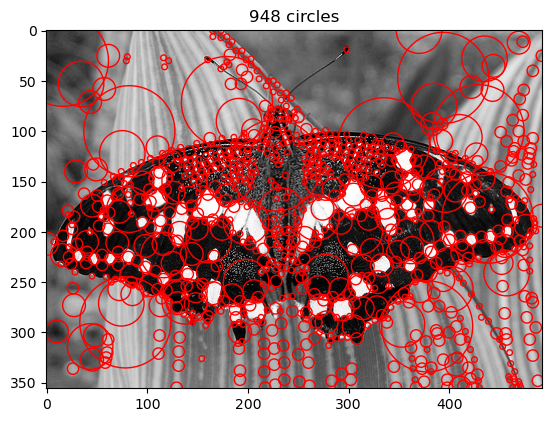

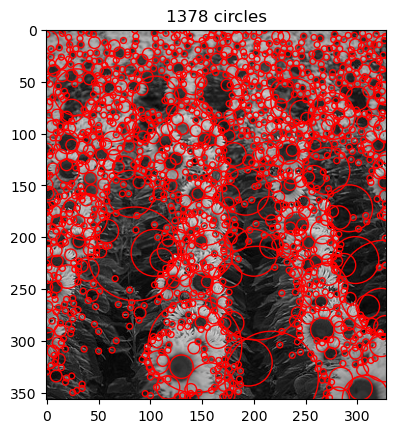

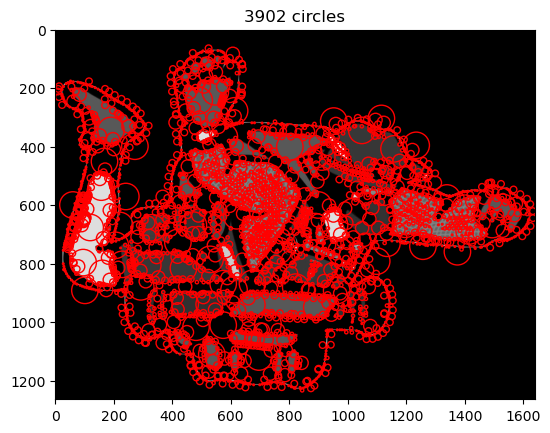

KeyboardInterrupt: 

In [ ]:


print(f"image size {images[0].shape}")
print(f"num of images {len(coordinates_per_image_ineff)}")

for i, coords in enumerate(coordinates_per_image_ineff):
   
    cx, cy, cz = coords
    sigmas = np.array([SIGMAS[z] for z in cz])
    radii = sigmas * sqt_2
    radii = radii.tolist()

    show_all_circles(images[i], cx, cy, radii, "ineff_"+filenames[i])


In [158]:
#scaled images

print(f"image size {images[0].shape}")
print(f"num of images {len(coordinates_per_image_eff)}")

for i, coords in enumerate(coordinates_per_image_eff):
   
    cx, cy, cz = coords
    sigmas = np.array([IMAGE_SCALES[z] for z in cz])
    radii = sigmas * sqt_2
    radii = radii.tolist()

    print(f"x :{type(cx[0])}, y {type(cy[0])}, radii {type(radii[0])}")
    show_all_circles(images[i], cx, cy, radii, "ineff_"+filenames[i])

image size (356, 493)
num of images 7
x :<class 'int'>, y <class 'int'>, radii <class 'float'>


TypeError: show_all_circles() missing 1 required positional argument: 'filename'